# Buoc 1: Load du lieu

In [9]:
# yyyy-mm-dd
def loaddata(from_date, to_date):
    from datetime import datetime
    # Import necessary modules
    from ssi_fc_data import fc_md_client, model
    import pandas as pd  # Import Pandas for DataFrame handling
    import json
    import configDataSSL

    # Create a Market Data Client
    # from_date = "01/11/2023"
    # to_date = "17/11/2023"

    # Chuyen tu yyyy-mm-dd sang dd/mm/yyyy cho phu hop SSI
    # Chuyển đổi chuỗi thành đối tượng datetime
    from_date = datetime.strptime(from_date, '%Y-%m-%d')
    to_date = datetime.strptime(to_date, '%Y-%m-%d')

    # Chuyển đổi đối tượng datetime sang định dạng 'dd/mm/yyyy'
    from_date = from_date.strftime('%d/%m/%Y')
    to_date = to_date.strftime('%d/%m/%Y')

    client = fc_md_client.MarketDataClient(configDataSSL)

    req = model.daily_ohlc('VCB', from_date, to_date) # Viet lai lay tu yfinance

    data_dict = client.daily_ohlc(configDataSSL, req)
  
    # Access the list of dictionaries in the "data" field
    data_list = data_dict['data']

    # Convert the list of dictionaries into a DataFrame
    data = pd.DataFrame(data_list)

    data = data.rename(columns={'TradingDate': 'Datetime'})
    # Chuyển đổi cột 'Datetime' từ 'dd/mm/yyyy' sang đối tượng datetime
    data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d/%m/%Y')

    # Định dạng lại cột 'Datetime' sang 'yyyy-mm-dd'
    data['Datetime'] = data['Datetime'].dt.strftime('%Y-%m-%d')

    # Print or work with the DataFrame

    return data

In [10]:
import yfinance as yf

def loaddataYFinance(from_date, to_date):
    data = yf.download('VCB.VN', start=from_date, end=to_date)
    data.reset_index(inplace=True)
    data = data.rename(columns={'Date': 'Datetime'})
    
    return data

# Buoc 2: Viet 3 ham kiem tra du lieu tin hieu

In [11]:
def kiemtratinhieu(data, from_date, to_date):
    import pandas as pd
    # data o tren

    data.set_index('Datetime', inplace=True)

    # Giả sử 'data' là DataFrame của bạn với dữ liệu lịch sử giá cổ phiếu
    data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
    data['High'] = pd.to_numeric(data['High'], errors='coerce')
    data['Low'] = pd.to_numeric(data['Low'], errors='coerce')
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    # Định nghĩa hàm để kiểm tra nến Doji chân dài
    def is_long_legged_doji(row):
        body_range = abs(row['Close'] - row['Open']) # Doji khong phan biet Open > Close hay Close > Open
        upper_shadow = row['High'] - max(row['Open'], row['Close'])
        lower_shadow = min(row['Open'], row['Close']) - row['Low']
        # Điều chỉnh ngưỡng này theo dữ liệu cụ thể của bạn
        doji_threshold = 0.1 / 100 * row['Close']
        return body_range <= doji_threshold and upper_shadow >= 2 * body_range and lower_shadow >= 2 * body_range

    # Định nghĩa hàm để kiểm tra nến tăng
    def is_bullish_candle(current_row, previous_row):
        return (current_row['Close'] > current_row['Open'] and
                current_row['Close'] > previous_row['Close'] and
                previous_row['Close'] <= previous_row['Open'])

    # Định nghĩa hàm để kiểm tra nến giảm
    def is_bearish_candle(current_row, previous_row):
        return (current_row['Close'] < current_row['Open'] and
                current_row['Close'] < previous_row['Close'] and
                previous_row['Close'] >= previous_row['Open'])

    # Lặp qua DataFrame 2 record cuối cùng để kiểm tra chiến lược mua
    buy_signals = []
    sell_signals = []

    # for i in range(0, len(data)): # Chi lay 2 nen
    for i in range(1, 2): # Chi lay 2 nen
        current_row = data.iloc[i]
        previous_row = data.iloc[i - 1]
        
        # Kiểm tra nến hiện tại có phải là nến tăng và nếu nến trước đó là nến Doji chân dài
        if is_bullish_candle(current_row, previous_row) and is_long_legged_doji(previous_row):
            # Nếu thỏa mãn cả ba điều kiện, thêm ngày vào danh sách tín hiệu mua
            buy_signals.append(current_row.name)  # .name sẽ lấy chỉ số (ngày) của hàng
        if is_bearish_candle(current_row, previous_row) and is_long_legged_doji(previous_row):
            sell_signals.append(current_row.name)

    # In ra danh sách các tín hiệu mua
    print("Buy signals " + from_date + " to " + to_date + " on dates: ", buy_signals)
    print("Sell signals " + from_date + " to " + to_date + " on dates: ", sell_signals)

# Show nen len de xem

In [12]:
def showdata(data):
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines

    def draw_candlestick_with_labels(ax, data):
        # Sử dụng enumerate để nhận vị trí chỉ số và dữ liệu hàng
        for i, (index, row) in enumerate(data.iterrows()):
            # Xác định màu sắc dựa trên giá Open và Close
            color = 'green' if row['Open'] <= row['Close'] else 'red'
            
            # Vẽ bóng nến (High và Low)
            ax.plot([i, i], [row['Low'], row['High']], color='black')
            
            # Vẽ thân nến (Open và Close)
            body_height = max(row['Close'] - row['Open'], 0.01)  # Đảm bảo có chiều cao tối thiểu
            body_bottom = min(row['Close'], row['Open'])
            open_close_rect = plt.Rectangle((i - 0.2, body_bottom), 0.4, body_height, 
                                            facecolor=color, edgecolor='black')
            ax.add_patch(open_close_rect)
            
            # Thêm nhãn giá
            ax.text(i, row['High'], f"{row['High']}", va='bottom', ha='center', fontsize=8)
            ax.text(i, row['Low'], f"{row['Low']}", va='top', ha='center', fontsize=8)
            ax.text(i - 0.2, row['Open'], f"{row['Open']}", va='center', ha='right', fontsize=8)
            ax.text(i + 0.2, row['Close'], f"{row['Close']}", va='center', ha='left', fontsize=8)

    # Khởi tạo plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Vẽ các nến với nhãn từ DataFrame
    draw_candlestick_with_labels(ax, data)

    # Thiết lập giới hạn cho biểu đồ
    ax.set_xlim(-1, len(data))
    ax.set_ylim(data['Low'].min() * 0.95, data['High'].max() * 1.05)  # Đặt giới hạn với một chút đệm

    # Thiết lập nhãn cho trục x
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels([index.strftime('%Y-%m-%d') for index in data.index], rotation=45)
    ax.set_ylabel('Price')

    # Hiển thị plot
    plt.show()

# Buoc 3: Auto Trade

In [5]:
import schedule
import time
import pandas as pd
from datetime import datetime, timedelta

def execute_trade():
    end_date = datetime.now() - timedelta(days=14)# Lấy ngày hôm nay
    start_date = end_date - timedelta(days=1)  # Lấy ngày trước ngày hiện tại

    # Chuyển đổi cột 'Datetime' từ 'dd/mm/yyyy' sang đối tượng datetime
    start_date = pd.to_datetime(start_date, format='%d/%m/%Y')
    end_date = pd.to_datetime(end_date, format='%d/%m/%Y')

    # Định dạng lại cột 'Datetime' sang 'yyyy-mm-dd'
    # Định dạng ngày tháng theo chuẩn (ví dụ: "2023-11-01")
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")

    data = loaddata(start_date_str, end_date_str)
    print(data)
    kiemtratinhieu(data, start_date_str, end_date_str)

# Lên lịch hàm execute_trade để chạy mỗi phút
# schedule.every(1).minute.do(execute_trade)
schedule.every(1).day.at("18:25").do(execute_trade)

while True:
    schedule.run_pending()  # Kiểm tra và thực hiện các công việc lên lịch
    time.sleep(1)

# Buoc 4: Backtest chien luoc Doji chan dai - Mua

In [20]:
def kiemtratinhieuBackTest(data, from_date, to_date):
    import pandas as pd
    # data o tren

    data.set_index('Datetime', inplace=True)

    # Giả sử 'data' là DataFrame của bạn với dữ liệu lịch sử giá cổ phiếu
    data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
    data['High'] = pd.to_numeric(data['High'], errors='coerce')
    data['Low'] = pd.to_numeric(data['Low'], errors='coerce')
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    # Định nghĩa hàm để kiểm tra nến Doji chân dài
    def is_long_legged_doji(row):
        body_range = abs(row['Close'] - row['Open']) # Doji khong phan biet Open > Close hay Close > Open
        upper_shadow = row['High'] - max(row['Open'], row['Close'])
        lower_shadow = min(row['Open'], row['Close']) - row['Low']
        # Điều chỉnh ngưỡng này theo dữ liệu cụ thể của bạn
        doji_threshold = 0.1 / 100 * row['Close']
        return body_range <= doji_threshold and upper_shadow >= 2 * body_range and lower_shadow >= 2 * body_range

    # Định nghĩa hàm để kiểm tra nến tăng
    def is_bullish_candle(current_row, previous_row):
        return (current_row['Close'] > current_row['Open'] and
                current_row['Close'] > previous_row['Close'] and
                previous_row['Close'] <= previous_row['Open'])

    # Định nghĩa hàm để kiểm tra nến giảm
    def is_bearish_candle(current_row, previous_row):
        return (current_row['Close'] < current_row['Open'] and
                current_row['Close'] < previous_row['Close'] and
                previous_row['Close'] >= previous_row['Open'])

    # Lặp qua DataFrame 2 record cuối cùng để kiểm tra chiến lược mua
    buy_signals = []
    sell_signals = []

    # Thêm các cột mới vào DataFrame để theo dõi tín hiệu và vị thế
    data['Signal'] = None
    data['Position'] = None

    position = None  # Theo dõi vị thế hiện tại: 'buy', 'sell', hoặc None

    for i in range(1, len(data) - 1):  # Lặp đến ngày áp chót của DataFrame
        current_row = data.iloc[i]
        next_day = data.index[i + 1]  # Lấy ngày tiếp theo
        previous_row = data.iloc[i - 1]

        if is_bullish_candle(current_row, previous_row) and is_long_legged_doji(previous_row):
            data.at[next_day, 'Signal'] = 'Buy'  # Đặt tín hiệu mua cho ngày tiếp theo
            data.at[next_day, 'Position'] = 'Buy'  # Đặt tín hiệu mua cho ngày tiếp theo
        # elif is_bearish_candle(current_row, previous_row) and is_long_legged_doji(previous_row):
        #     data.at[next_day, 'Signal'] = 'Sell'  # Đặt tín hiệu bán cho ngày tiếp theo
        #     position = 'sell'

    # In ra danh sách các tín hiệu mua và bán
    print("Buy signals " + from_date + " to " + to_date + " on dates: ", data[data['Signal'] == 'Buy'].index.tolist())
    # print("Sell signals " + from_date + " to " + to_date + " on dates: ", data[data['Signal'] == 'Sell'].index.tolist())

    return data

def kiemtraMuaBackTest(data, initial_capital, shares_per_trade):
    capital = initial_capital
    shares_owned = 0
    transactions = []

    # Thêm cột để theo dõi vốn và số lượng cổ phiếu nắm giữ
    data['Capital'] = initial_capital
    data['Shares_Held'] = 0

    for index, row in data.iterrows():
        if row['Signal'] == 'Buy' and capital >= row['Close'] * shares_per_trade:
            # Thực hiện mua
            shares_owned += shares_per_trade
            capital -= row['Close'] * shares_per_trade
            transactions.append((index, 'Buy', shares_per_trade, row['Close'], capital))

            # Cập nhật thông tin vốn và số lượng cổ phiếu nắm giữ
            data.at[index, 'Capital'] = capital
            data.at[index, 'Shares_Held'] = shares_owned
        else:
            data.at[index, 'Capital'] = capital
            data.at[index, 'Shares_Held'] = shares_owned
            
    # Tính toán giá trị danh mục cuối cùng
    final_value = capital + shares_owned * data.iloc[-1]['Close']
    data.to_csv('kiemtraMuaBackTest.csv')
    return transactions, final_value, data

In [21]:
data = loaddata('2023-11-01', '2024-01-25')
kiemtratinhieuBackTest(data, '2023-11-01', '2024-01-25')
kiemtraMuaBackTest(data, 100000000, 100)

Buy signals 2023-11-01 to 2024-01-25 on dates:  ['2023-11-16', '2023-12-26']


([('2023-11-16', 'Buy', 100, 88000, 91200000),
  ('2023-12-26', 'Buy', 100, 82800, 82920000)],
 101120000,
            Symbol Market  Time   Open   High    Low  Close   Volume  \
 Datetime                                                              
 2023-11-01    VCB   HOSE  None  86800  87800  86100  87800  1479100   
 2023-11-02    VCB   HOSE  None  88000  89000  86600  89000  1057500   
 2023-11-03    VCB   HOSE  None  89000  89400  88100  88900  1086600   
 2023-11-06    VCB   HOSE  None  88900  89800  88500  89500   774800   
 2023-11-07    VCB   HOSE  None  89000  89300  88300  88300   413900   
 ...           ...    ...   ...    ...    ...    ...    ...      ...   
 2024-01-19    VCB   HOSE  None  91000  93000  90400  92600  1472600   
 2024-01-22    VCB   HOSE  None  93500  93500  92000  92000  1046300   
 2024-01-23    VCB   HOSE  None  92100  92400  90400  91500  1256900   
 2024-01-24    VCB   HOSE  None  91600  92000  90900  91100   744700   
 2024-01-25    VCB   HOSE  No

## ______Buoc 4.1: Thu thap du lieu vao DataWareHouse

In [ ]:
import yfinance as yf
import pandas as pd
import sqlalchemy

# Tải dữ liệu OHLCV
symbol = "VCB.VN"
start_date = "2023-01-01"
end_date = "2023-12-31"
ohlcv = yf.download(symbol, start=start_date, end=end_date, interval="1d")

# Thêm cột Timestamp nếu cần
ohlcv.reset_index(inplace=True)

# Chọn chỉ các cột cần thiết
try:
    ohlcv = ohlcv[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]
except Exception as e:
    ohlcv = ohlcv[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    ohlcv.rename(columns={'Date': 'Datetime'}, inplace=True)

# Định nghĩa thông tin kết nối SQL Server
server = '.'
database = 'Cole'
username = 'sa'
password = '1'
driver = 'ODBC Driver 17 for SQL Server'

# Tạo engine kết nối
connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}"
engine = sqlalchemy.create_engine(connection_string)

# Lưu DataFrame vào SQL Server
table_name = 'Trading_Data_ChungKhoan'
ohlcv.to_sql(table_name, con=engine, if_exists='append', index=False)

## ______Buoc 4.2 Backtest chien luoc voi du lieu API

In [6]:
import pandas as pd
from datetime import datetime, timedelta

# Thiết lập ngày bắt đầu và kết thúc cho backtesting
start_date = '2023-08-01'
end_date = '2023-11-29'
initial_capital = 100000000
shares_per_trade = 10

data = loaddata(start_date, end_date)
dataBackTest = kiemtratinhieuBackTest(data, start_date, end_date) # Signal Postion
transactions, final_value, dataFinal = kiemtraMuaBackTest(dataBackTest, initial_capital, shares_per_trade) # Capital Share

dataFinal.to_csv('Buoi 9.1 Thuc hanh 1-2-3-4 Doji chan dai_mua Chung khoan kiemtraMuaBackTest.csv')
print("Các giao dịch thực hiện:")
for transaction in transactions:
    print(transaction)

print(f"Giá trị đầu tư ban đầu: {initial_capital}")
print(f'Tổng lợi nhuận: {final_value - initial_capital}')
print(f"Giá trị cuối cùng của danh mục đầu tư: {final_value}")

Buy signals 2023-08-01 to 2023-11-29 on dates:  ['2023-08-29', '2023-09-06', '2023-10-25', '2023-11-16']
Các giao dịch thực hiện:
('2023-08-29', 'Buy', 10, 88400, 99116000)
('2023-09-06', 'Buy', 10, 90200, 98214000)
('2023-10-25', 'Buy', 10, 85800, 97356000)
('2023-11-16', 'Buy', 10, 88000, 96476000)
Giá trị đầu tư ban đầu: 100000000
Tổng lợi nhuận: -120000
Giá trị cuối cùng của danh mục đầu tư: 99880000


# ______Buoc 4.2.1 Ve bieu do thi truong va chien luoc

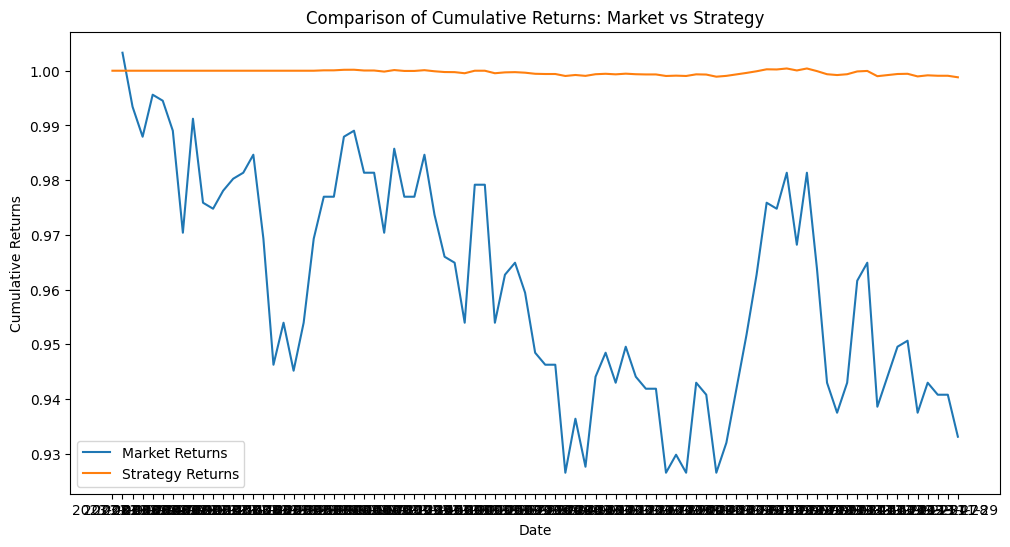

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Đảm bảo rằng 'data' là DataFrame chứa dữ liệu cần thiết
data = dataFinal # Tải dữ liệu của bạn

# Tính lợi nhuận lũy kế từ thị trường
data['Market_Return'] = data['Close'].pct_change()
data['Cumulative_Market_Returns'] = (1 + data['Market_Return']).cumprod()

# Giả định về các giá trị cần thiết cho chiến lược
initial_capital = 100000000  # Vốn ban đầu
lot_size = 10  # Số lượng cổ phiếu mua mỗi lần

# Tính lợi nhuận lũy kế từ chiến lược
data['Strategy_Value'] = data['Capital'] + data['Shares_Held'] * data['Close']  # Sửa 'Lots_Bought' thành 'Shares_Held' nếu cần
data['Cumulative_Strategy_Returns'] = data['Strategy_Value'] / initial_capital

# Lưu dữ liệu nếu cần
data.to_csv('Buoi 9.1 Thuc hanh 1-2-3-4 Doji chan dai_mua Chung khoan_Market_vs_Strategy.csv')

# Vẽ biểu đồ so sánh lợi nhuận lũy kế
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cumulative_Market_Returns'], label='Market Returns')
plt.plot(data.index, data['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.title('Comparison of Cumulative Returns: Market vs Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

## ______Buoc 4.3 Backtest chien luoc voi du lieu DataWareHouse